# Data Exploration and Processing

The dataset has 95 features, far too many to properly predict the target (if the company is bankrupt or not). Therefore, some data exploration and processing must be done in order to narrow down the dataset.

In [39]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from scipy.stats import shapiro

Ideas for feature reduction:
- Remove low variance features
- Remove features with low correlation to target
- Transform data into Gaussian and remove features that are still non-Gaussian

In [40]:
# Read data and separate into features and target
df = pd.read_csv('datasets/train_data.csv')
X_train = df.drop('Bankrupt?', axis=1)
y_train = df['Bankrupt?']

In [41]:
# Remove features where the variance is less than 0.001
var = X_train.var()
low_variance_cols = np.where(var < 0.001)[0].tolist()
high_variance_df = X_train.drop(X_train.columns[low_variance_cols], axis=1)

In [42]:
# Remove features with a low correlation to the target
correlations = df.corr()['Bankrupt?'].abs().sort_values(ascending=False)
correlations = correlations.drop('Bankrupt?')
high_correlation_cols = correlations.head(high_variance_df.shape[1])
high_correlation_cols = high_correlation_cols.index.tolist()
high_correlation_df = df.loc[:,high_correlation_cols]

In [43]:
# Resulting features are the intersection of the high variance and high correlation features
high_var_corr_cols = list(set(high_variance_df.columns.tolist()).intersection(set(high_correlation_df.columns.tolist())))
high_var_corr_df = X_train.loc[:,high_var_corr_cols]

In [44]:
# Transform all features into Gaussian, then drop features that are still not Gaussian
qt = QuantileTransformer(output_distribution='normal', random_state=42)
print(high_var_corr_df.columns)
df_qt = qt.fit_transform(high_var_corr_df)
joblib.dump(qt, 'qt.pkl')
high_var_corr_df = pd.DataFrame(df_qt, columns=high_var_corr_df.columns)

cols_to_drop = []
for i in high_var_corr_df.columns:
    stat, p = shapiro(high_var_corr_df.loc[:,i])
    if stat < 0.9:
        cols_to_drop.append(i)

print(f'Columns being dropped: {cols_to_drop}')
high_var_corr_df = high_var_corr_df.drop(columns=cols_to_drop)

# Add bankrupt column back
high_var_corr_df.insert(0, 'Bankrupt?', y_train)

Index([' Working Capital to Total Assets', ' Net Value Per Share (A)',
       ' Current Liability to Assets', ' Fixed Assets Turnover Frequency',
       ' Total Asset Turnover',
       ' ROA(C) before interest and depreciation before interest',
       ' Cash/Total Assets', ' Net Value Per Share (B)',
       ' Current Liability to Current Assets', ' Revenue per person',
       ' ROA(A) before interest and % after tax', ' Net Value Growth Rate',
       ' Net Value Per Share (C)', ' CFO to Assets', ' Equity to Liability',
       ' Net Income to Total Assets',
       ' Per Share Net profit before tax (Yuan ¥)', ' Tax rate (A)',
       ' Net profit before tax/Paid-in capital', ' Cash Flow to Total Assets',
       ' Fixed Assets to Assets', ' Liability-Assets Flag',
       ' Cash/Current Liability',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Funds to Liability', ' Net worth/Assets',
       ' Persistent EPS in the Last Four Seasons',
       ' Quick Assets/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5807.
  res = hypotest_fun_out(*samples, **kwds)


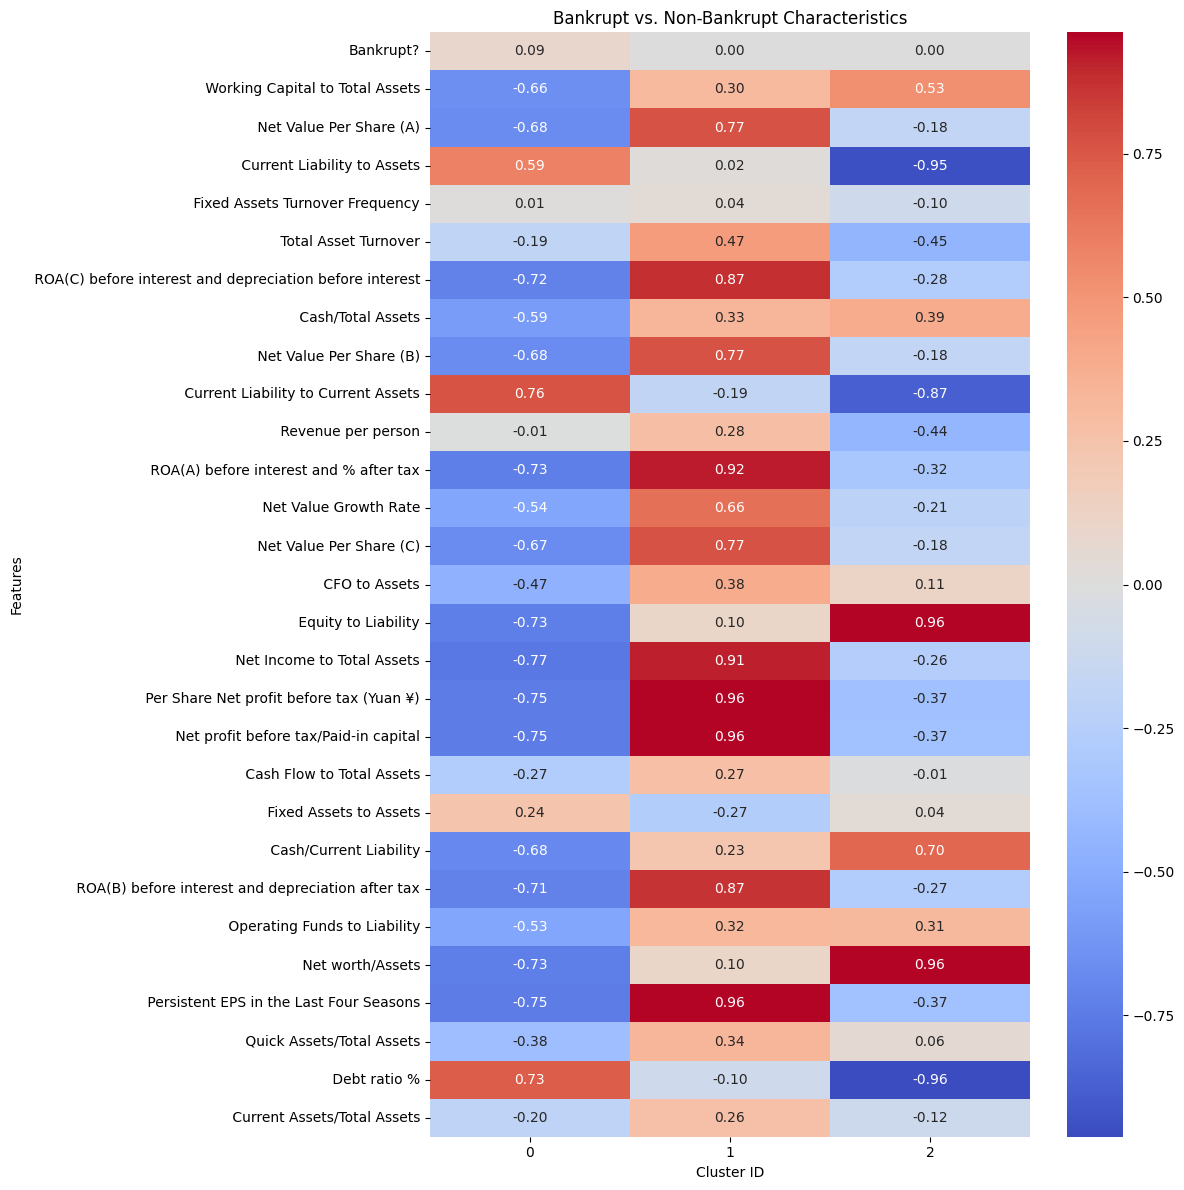

In [45]:
# Perform clustering on the data and visualize
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_ids = kmeans.fit_predict(high_var_corr_df.drop('Bankrupt?', axis=1))

# Add cluster id column
cluster_df = high_var_corr_df.copy()
cluster_df.insert(1, 'Cluster ID', cluster_ids)

# Visualize characteristics of each cluster
cluster_df_mean = cluster_df.groupby('Cluster ID').mean()
plt.figure(figsize=(12, 12))
sns.heatmap(cluster_df_mean.T, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Bankrupt vs. Non-Bankrupt Characteristics')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [46]:
cluster_summary = cluster_df.groupby('Cluster ID')['Bankrupt?'].agg(
    Total_Companies='count',
    Bankrupt_Companies='sum',
    Non_Bankrupt_Companies=lambda x: (x == 0).sum(),
    Bankrupt_Percentage=lambda x: (x.sum() / len(x)) * 100
).reset_index()

cluster_summary

,Cluster ID,Total_Companies,Bankrupt_Companies,Non_Bankrupt_Companies,Bankrupt_Percentage
0,0,2170,189,1981,8.709677
1,1,2228,2,2226,0.089767
2,2,1409,7,1402,0.496806


Cluster 0 had the highest percentage of bankrupt companies (8.7%), while cluster 1 had the lowest percentage of bankrupt companies (0.09%). As shown in the heatmap, there are some key features:

#### Debt Ratio
Although debt ratio seems like a good indicator of bankruptcy, cluster 2 had a lower debt ratio than cluster 1 despite having a higher rate of bankruptcy.

#### ROA and EPS
ROA and EPS seem to be good indicators to identify which cluster a data point belongs in. Companies in cluster 0 tend to have a very negative ROA and EPS, while companies in clusters 1 and 2 tend to have positive ones.

#### Growth Rate
Companies in clusters 1 and 2 tend to have better growth rates than those in cluster 0, suggesting that companies facing bankruptcy are shrinking.

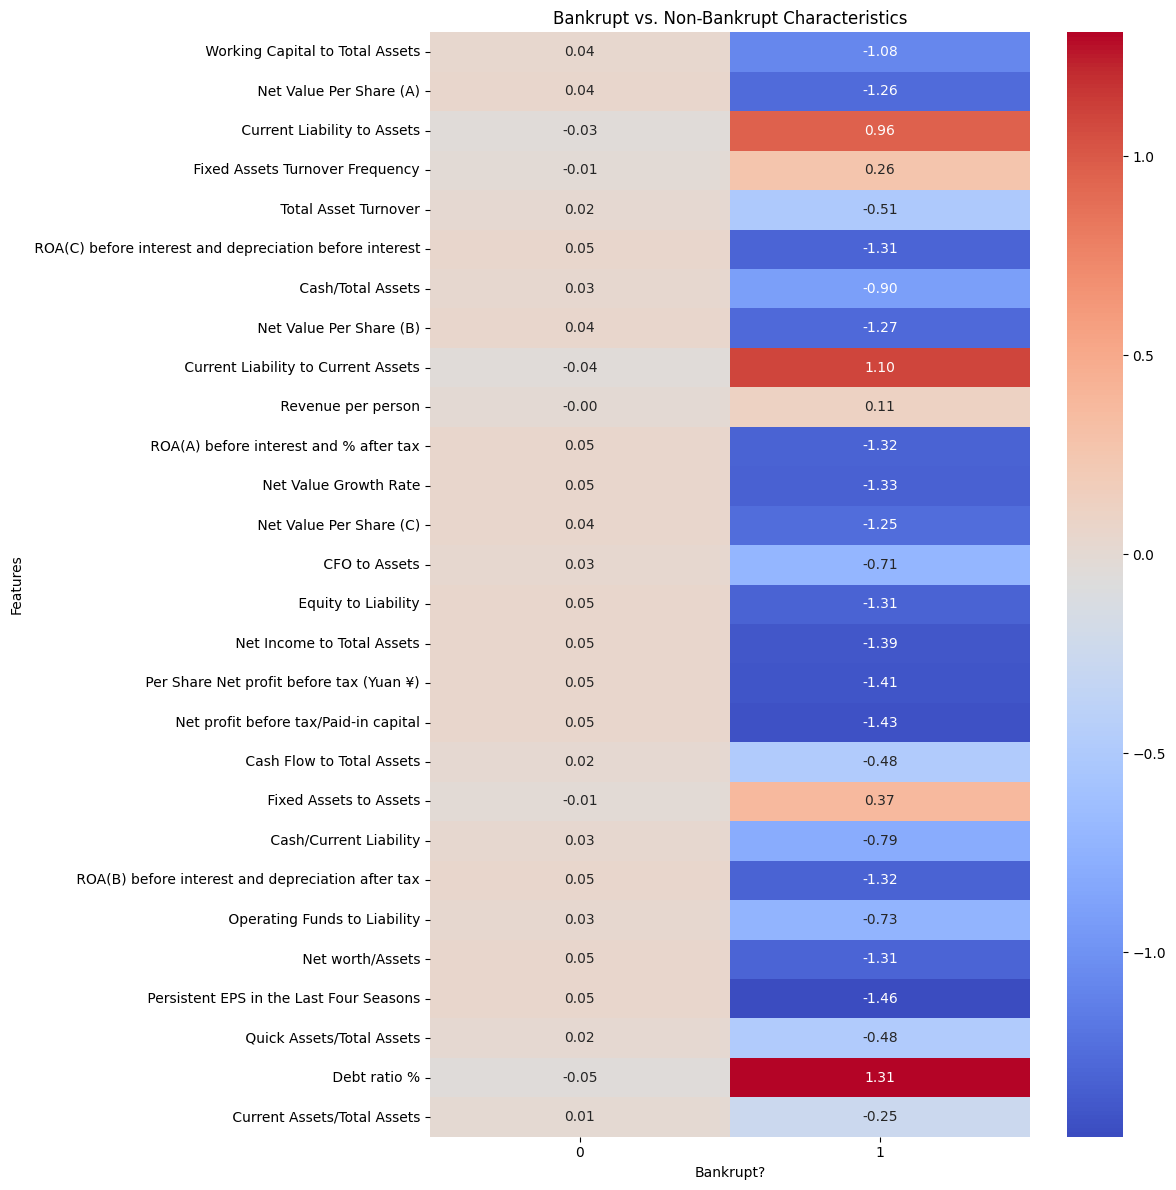

In [47]:
# Visualize characteristics of bankrupt and non-bankrupt companies
df_mean = high_var_corr_df.groupby('Bankrupt?').mean()
plt.figure(figsize=(12, 12))
sns.heatmap(df_mean.T, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Bankrupt vs. Non-Bankrupt Characteristics')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

While non-bankrupt companies have each feature's mean centered around 0, bankrupt companies have a few notable characteristics:
- High debt ratio: companies that have a high level of debt compared to their assets are at a higher risk of bankruptcy
- Negative growth rate: companies where its assets/book value are shrinking over time are at a higher risk of bankruptcy
- Negative EPS and ROA: companies that do not consistently return a profit are at a higher risk of bankruptcy. This could also indicate that a company is still in its growth stage.

In [48]:
# Export data
high_var_corr_df.to_csv('datasets/processed_train_data.csv',index=False)